# **Gender Prediction**

## **Powered by Leonardo Cofone**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from os.path import exists
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

2025-06-29 11:46:02.674228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751197562.863342      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751197562.918326      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **PREPROCESSING**

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_df = pd.read_csv("/kaggle/input/fairface/fairface/fairface_label_train.csv")
val_df = pd.read_csv("/kaggle/input/fairface/fairface/fairface_label_val.csv")

gender_map = {'Male': 0, 'Female': 1}
train_df['gender'] = train_df['gender'].map(gender_map)
val_df['gender'] = val_df['gender'].map(gender_map)

train_df['file'] = "/kaggle/input/fairface/fairface/" + train_df['file']
val_df['file'] = "/kaggle/input/fairface/fairface/" + val_df['file']

val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['gender'], random_state=42)

print(f"train set: {len(train_df)} immagini")
print(f"Val set: {len(val_df)} immagini")
print(f"Test set: {len(test_df)} immagini")

train set: 86744 immagini
Val set: 5477 immagini
Test set: 5477 immagini


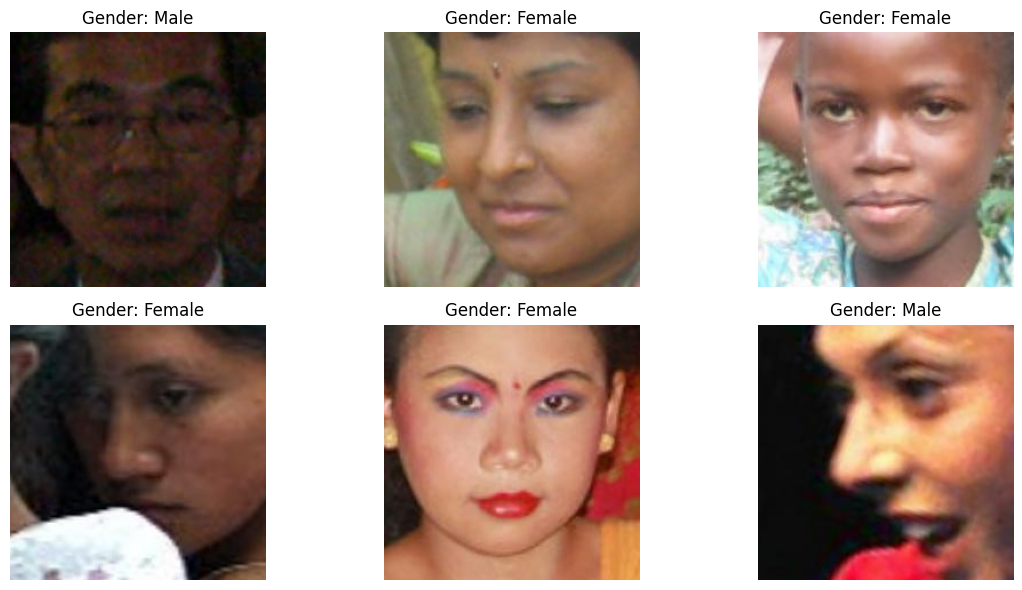

In [3]:
def show_examples(df, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = plt.imread(df.iloc[i]['file'])
        gender = df.iloc[i]['gender']
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title("Gender: {}".format("Male" if gender == 0 else "Female"))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(train_df)

In [4]:
def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

def create_dataset(df, shuffle=True):
    paths = df['file'].values
    labels = df['gender'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, shuffle=True)
val_ds = create_dataset(val_df, shuffle=False)
test_ds = create_dataset(test_df, shuffle=False)

I0000 00:00:1751197578.043596      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


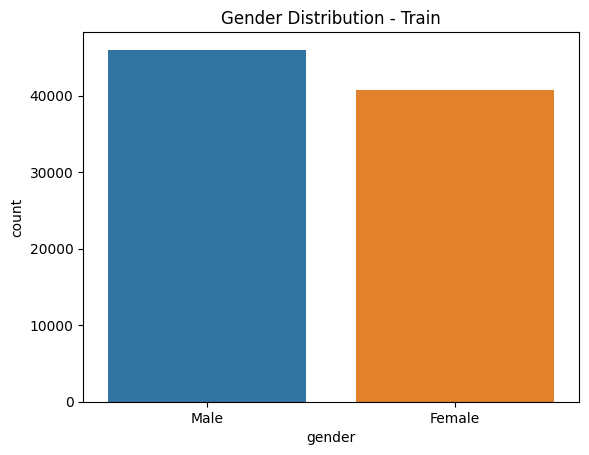

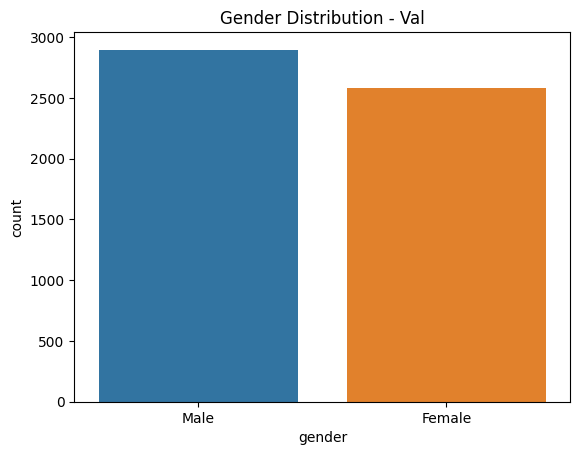

Train set:
gender
0    53.01%
1    46.99%
Name: proportion, dtype: object
Val set:
gender
0    52.88%
1    47.12%
Name: proportion, dtype: object


In [5]:
sns.countplot(data=train_df, x='gender')
plt.title('Gender Distribution - Train')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

sns.countplot(data=val_df, x='gender')
plt.title('Gender Distribution - Val')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

print("Train set:")
print(train_df['gender'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))
print("Val set:")
print(val_df['gender'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

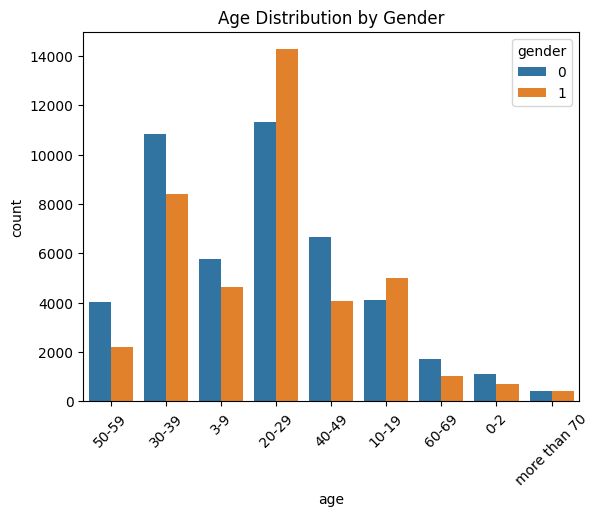

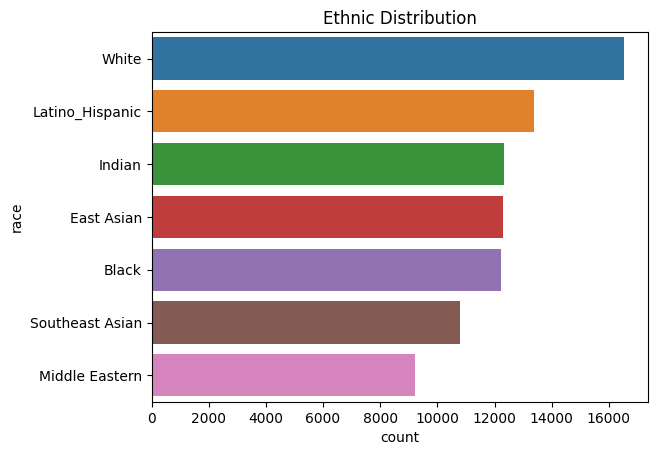

In [6]:
sns.countplot(data=train_df, x='age', hue='gender')
plt.title('Age Distribution by Gender')
plt.xticks(rotation=45)
plt.show()

sns.countplot(data=train_df, y='race', order=train_df['race'].value_counts().index)
plt.title('Ethnic Distribution')
plt.show()

In [7]:
#This cell can take a little bit to run...
'''
def check_missing_files(df):
    missing = [f for f in df['file'] if not os.path.exists(f)]
    print(f"Missing files: {len(missing)}")
    if missing:
        print(missing[:5])

check_missing_files(train_df)
check_missing_files(val_df)
'''

#Missing files: 0
#Missing files: 0

'\ndef check_missing_files(df):\n    missing = [f for f in df[\'file\'] if not os.path.exists(f)]\n    print(f"Missing files: {len(missing)}")\n    if missing:\n        print(missing[:5])\n\ncheck_missing_files(train_df)\ncheck_missing_files(val_df)\n'

## **TRAINING**

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,004,865 (110.64 MB)

 Trainable params: 29,000,897 (110.63 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [9]:
epochs = 50

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/50


I0000 00:00:1751197590.202852      61 service.cc:148] XLA service 0x7aa950008f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751197590.203553      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751197591.065471      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-29 11:46:41.202922: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,64,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-29 11:46:41.381915: E external/l

   1/2711 ━━━━━━━━━━━━━━━━━━━━ 21:47:52 29s/step - accuracy: 0.5938 - loss: 7.9559 - precision: 0.5714 - recall: 0.7500

I0000 00:00:1751197609.378178      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2711/2711 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6477 - loss: 4.9215 - precision: 0.6276 - recall: 0.6247
Epoch 1: val_loss improved from inf to 0.73904, saving model to best_model.keras
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 389s 133ms/step - accuracy: 0.6477 - loss: 4.9208 - precision: 0.6276 - recall: 0.6247 - val_accuracy: 0.7511 - val_loss: 0.7390 - val_precision: 0.7523 - val_recall: 0.7036 - learning_rate: 1.0000e-04
Epoch 2/50
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7522 - loss: 0.6624 - precision: 0.7402 - recall: 0.7317
Epoch 2: val_loss improved from 0.73904 to 0.51077, saving model to best_model.keras
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 338s 124ms/step - accuracy: 0.7522 - loss: 0.6623 - precision: 0.7402 - recall: 0.7317 - val_accuracy: 0.7919 - val_loss: 0.5108 - val_precision: 0.7450 - val_recall: 0.8489 - learning_rate: 1.0000e-04
Epoch 3/50
2711/2711 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7922 - loss: 0.5327 - precision: 0.7849 - recall: 0.771

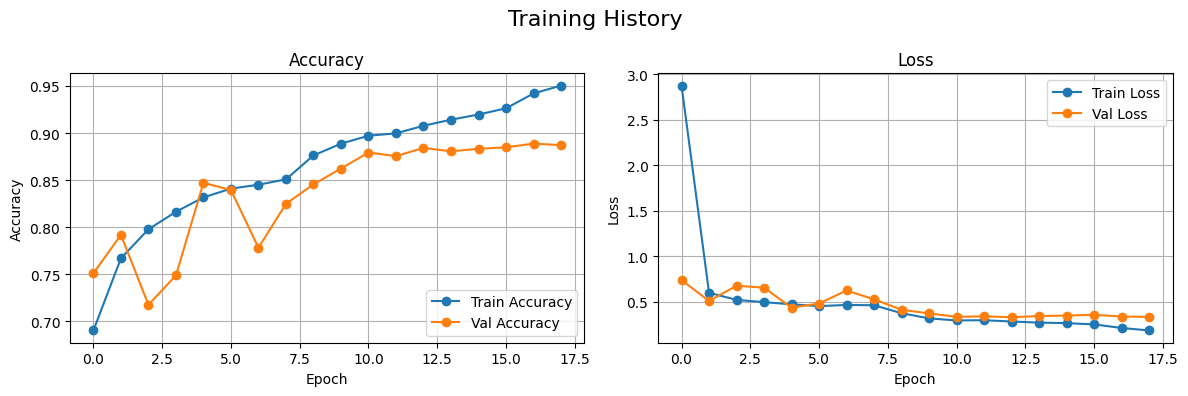

In [10]:
def plot_history(history):
    if history is None or not hasattr(history, "history"):
        print("No history available.")
        return

    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    if not acc or not loss:
        print("History does not contain sufficient metrics.")
        return

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    #ACCURACY
    ax[0].plot(acc, label='Train Accuracy', marker='o')
    ax[0].plot(val_acc, label='Val Accuracy', marker='o')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].grid(True)

    #LOSS
    ax[1].plot(loss, label='Train Loss', marker='o')
    ax[1].plot(val_loss, label='Val Loss', marker='o')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].grid(True)

    plt.suptitle("Training History", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_history(history)

## **TUNING**

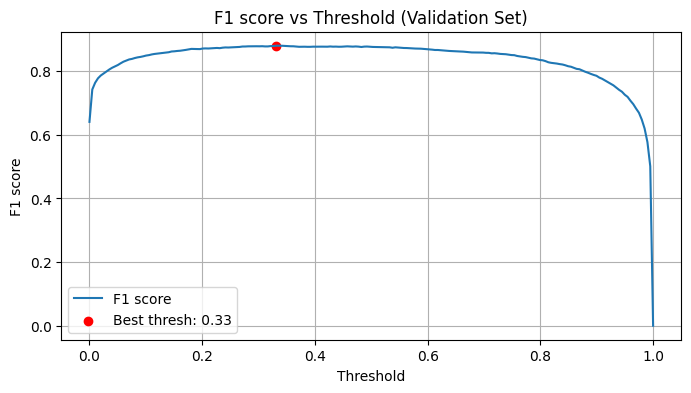

Best threshold: 0.332 with F1 score: 0.8799


In [11]:
def get_preds_and_labels(model, dataset):
    y_true = []
    y_scores = []
    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_scores.extend(preds.flatten())
        y_true.extend(y_batch.numpy())
    return np.array(y_true), np.array(y_scores)

def threshold_tuning(model, val_ds):
    y_true, y_scores = get_preds_and_labels(model, val_ds)
    thresholds = np.linspace(0, 1, 200)
    f1_scores = [f1_score(y_true, y_scores > t) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    plt.figure(figsize=(8,4))
    plt.plot(thresholds, f1_scores, label='F1 score')
    plt.scatter(best_thresh, best_f1, color='red', label=f'Best thresh: {best_thresh:.2f}')
    plt.title('F1 score vs Threshold (Validation Set)')
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Best threshold: {best_thresh:.3f} with F1 score: {best_f1:.4f}")
    return best_thresh

best_threshold = threshold_tuning(model, val_ds)

## **TESTING**

Metriche finali sul Test Set
AUC:       0.9566
Precision: 0.8343
Recall:    0.9128
F1 Score:  0.8718

Classification Report:
              precision    recall  f1-score   support

        Male       0.92      0.84      0.88      2896
      Female       0.83      0.91      0.87      2581

    accuracy                           0.87      5477
   macro avg       0.87      0.88      0.87      5477
weighted avg       0.88      0.87      0.87      5477



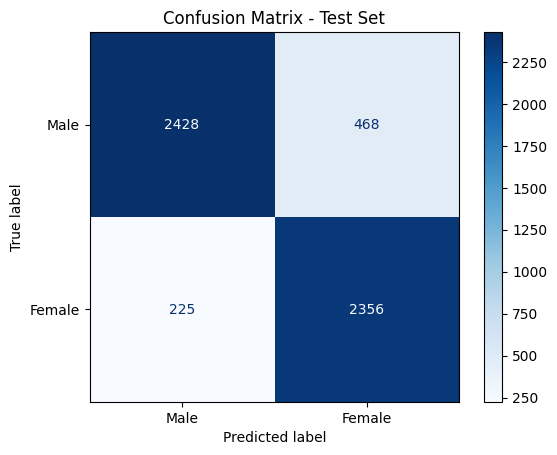

In [12]:
def evaluate_test(model, test_ds, threshold):
    y_true, y_scores = get_preds_and_labels(model, test_ds)
    y_pred = (y_scores > threshold).astype(int)

    print("Metriche finali sul Test Set")
    print(f"AUC:       {roc_auc_score(y_true, y_scores):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Male", "Female"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

evaluate_test(model, test_ds, best_threshold)

## **SAVE**

In [13]:
model.save("Gender_prediction_final.h5")
model.save("Gender_prediction_final.keras")

with open("best_threshold.txt", "w") as f:
    f.write(str(best_threshold))



#HOW TO USE THE MODEL AND THE THRESHOLD
'''
from tensorflow.keras.models import load_model

model_ker = load_model("Gender_prediction_final.keras")
model_h5 = load_model("Gender_prediction_final.h5")

with open("best_threshold.txt", "r") as f:
    best_threshold = float(f.read())

print("Loaded threshold:", best_threshold)
'''

'\nfrom tensorflow.keras.models import load_model\n\nmodel_ker = load_model("Gender_prediction_final.keras")\nmodel_h5 = load_model("Gender_prediction_final.h5")\n\nwith open("best_threshold.txt", "r") as f:\n    best_threshold = float(f.read())\n\nprint("Loaded threshold:", best_threshold)\n'